# Char model

In [1]:
import numpy as np
from char_dataset import CharDataset
from char_model import CharRNN

## Dataset

In [2]:
dataset = CharDataset()
dataset.load('data/dostoevsky.txt')  # dostoevsky.txt  anna.txt
model_path = 'models/dostoevsky-001/'

## Build

In [3]:
import os
from utils import make_dir
import numpy as np
import tensorflow as tf
import pickle
from visualization import show_train_stats

class CharRNN:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        # state
        self.tr_step   = 0
        self.tr_epoch  = 0
        self.tr_losses = []
        
    
    def _make_rnn_cell(self, num_units, num_layers, keep_prob):
        def make_layer():
            l = tf.contrib.rnn.BasicLSTMCell(num_units)
            l = tf.contrib.rnn.DropoutWrapper(l, output_keep_prob=keep_prob)
            return l        
        layers = [make_layer() for _ in range(num_layers)]
        cell   = tf.contrib.rnn.MultiRNNCell(layers)
        return cell

    
    def _make_loss(self, logits, targets, lstm_size, num_classes):
        loss = tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, 
            labels=tf.one_hot(targets, num_classes))
        loss = tf.reduce_mean(loss)
        return loss
    

    def _make_optimizer(self, loss, lr, grad_clip):
        tr_vars   = tf.trainable_variables()
        grads, _  = tf.clip_by_global_norm(tf.gradients(loss, tr_vars), grad_clip)
        train_op  = tf.train.AdamOptimizer(lr)
        optimizer = train_op.apply_gradients(zip(grads, tr_vars))
        return optimizer
    
    
    def _get_initial_state(self, batch_size):
        return self._sess.run(self.initial_state, feed_dict={self.batch_size_pl: batch_size})

    
    def build(self, num_units, num_layers, grad_clip):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        self._scope  = "char_rnn"
        with self._graph.as_default(), tf.variable_scope(self._scope):
            # placeholders
            self.inputs_pl     = tf.placeholder(tf.int32, [None, None], name='inputs')
            self.targets_pl    = tf.placeholder(tf.int32, [None, None], name='targets')
            self.seq_length_pl = tf.placeholder(tf.int32, [None], 'seq_lengths')
            self.batch_size_pl = tf.placeholder(tf.int32, shape=[], name='batch_size')
            self.keep_prob_pl  = tf.placeholder(tf.float32, name='keep_prob')
            self.lr_pl         = tf.placeholder(tf.float32, name='learning_rate')

            # network
            embed              = tf.one_hot(self.inputs_pl, self.num_classes)
            cell               = self._make_rnn_cell(num_units, num_layers, self.keep_prob_pl)
            initial_state      = cell.zero_state(self.batch_size_pl, tf.float32)
            outputs, state     = tf.nn.dynamic_rnn(cell, embed, self.seq_length_pl, initial_state, dtype=tf.float32)
            self.initial_state = initial_state
            self.final_state   = state

            # prediction
            logits             = tf.layers.dense(outputs, self.num_classes)
            self.prediction    = tf.nn.softmax(logits, name='predictions')

            # training
            self.loss_op       = self._make_loss(logits, self.targets_pl, num_units, self.num_classes)
            self.train_op      = self._make_optimizer(self.loss_op, self.lr_pl, grad_clip)
            
            # utils
            self.init_op       = tf.global_variables_initializer()
            self._saver        = tf.train.Saver()

        # session
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.4
        self._sess = tf.Session(graph=self._graph, config=config)
        self._sess.run(self.init_op)
        
        
    def train(self, dataset, seq_length, epochs, batch_size, keep_prob, learning_rate, log_every=10, mean_win=10):
        try:
            for self.tr_epoch in range(self.tr_epoch, epochs):
                state = self._get_initial_state(batch_size)

                for x, y in dataset.get_batches(batch_size, seq_length):
                    self.tr_step += 1
                    tr_loss, state, _ = self._sess.run(
                        [self.loss_op, self.final_state, self.train_op], 
                        feed_dict = {
                            self.inputs_pl    : x,
                            self.targets_pl   : y,
                            self.seq_length_pl: [seq_length, ]*batch_size,
                            self.initial_state: state,
                            self.keep_prob_pl : keep_prob,
                            self.lr_pl        : learning_rate,
                    })
                    self.tr_losses.append(tr_loss)
                    
                    if self.tr_step % log_every == 0:
                        show_train_stats(self.tr_epoch, self.tr_step, self.tr_losses, mean_win)
                        
        except KeyboardInterrupt:
            show_train_stats(self.tr_epoch, self.tr_step, self.tr_losses, mean_win)
            

    def save(self, path):
        make_dir(path)
        pickle.dump([self.tr_epoch, self.tr_step, self.tr_losses], open(os.path.join(path, "state.p"), "wb"))
        self._saver.save(self._sess, path)
        
    def restore(self, path):
        try:
             [self.tr_epoch, self.tr_step, self.tr_losses] = pickle.load(open(os.path.join(path, "state.p"), "rb"))
        except: 
            print("State not found at", path)
        self._saver.restore(self._sess, path)
        
    def predict(self, x, state, seq_len):
        pred, state = self._sess.run(
            [self.prediction, self.final_state], 
            feed_dict={
                self.inputs_pl    : x,
                self.seq_length_pl: [seq_len],
                self.initial_state: state,
                self.keep_prob_pl : 1.
            })
        return pred, state
    
    def sample(self, dataset, n_samples, top_n, prime):
        seq_len = 1
        def pick_top_n(pred, vocab_size, top_n):
            p = np.squeeze(pred)
            p[np.argsort(p)[:-top_n]] = 0
            p = p / np.sum(p)
            c = np.random.choice(vocab_size, 1, p=p)[0]
            return c

        samples = [c for c in prime]
        state = self._get_initial_state(batch_size = 1)

        for c in prime:
            x      = np.zeros([1, seq_len])
            x[0,0] = dataset.vocab_to_int[c]
            preds, state = self.predict(x, state, seq_len)
        c = pick_top_n(preds, self.num_classes, top_n)
        samples.append(dataset.int_to_vocab[c])

        for i in range(n_samples):
            x[0,0] = c
            preds, state = self.predict(x, state, seq_len)
            c = pick_top_n(preds, self.num_classes, top_n)
            samples.append(dataset.int_to_vocab[c])

        return ''.join(samples)

In [4]:
num_layers  = 2
num_units   = 512
grad_clip   = 5.0

model = CharRNN(
    num_classes = len(dataset.vocab))

with tf.device('/device:GPU:0'):
    model.build(
        num_units  = num_units, 
        num_layers = num_layers, 
        grad_clip  = grad_clip)

## Train

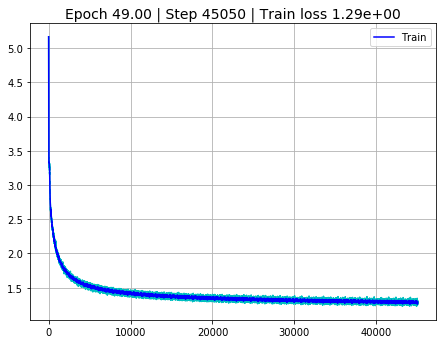

CPU times: user 8h 16min 59s, sys: 1h 53min 38s, total: 10h 10min 37s
Wall time: 4h 49s


In [7]:
%%time
model.train(
    epochs        = 50, 
    batch_size    = 128, 
    seq_length    = 100,
    learning_rate = 1e-3, 
    keep_prob     = .5,
    dataset       = dataset)
model.save(model_path)

## Test

In [6]:
primes = ['МОК запретил российским олимпийцам использовать национальную символику']
for prime in primes:
    print('-'*50)
    samp = model.sample(dataset, n_samples=300, top_n=3, prime=prime)
    samp = samp.replace('\n', '\n\n')
    print(samp)

--------------------------------------------------
МОК запретил российским олимпийцам использовать национальную символикую и странно стану и стояла в себя столько перед ним и не знал. Но никогда не подняла и стал при нем странным собственном стольком собственной возвращение, и нет, он не совсем не понимал несколько случай, и не подобно подоздить на столо в ней становится и несколько предположения совершиво возрестить с


## Restore

In [6]:
model.restore(model_path)

INFO:tensorflow:Restoring parameters from models/dostoevsky-001/
